# Forecasting non-stationary time series

#### In chapters 4, 5, and 6 we covered the moving average model, MA(q)); the autoregressive model, AR(p)); and the ARMA model, ARMA(p,q). We saw how these models can only be used for stationary time series, which required us to apply transformations, mainly differencing, and test for stationarity using the ADF test. In the examples that we covered, the forecasts from each model returned differenced values, which required us to reverse this transformation in order to bring the values back to the scale of the original data.



#### Now we’ll add another component to the ARMA(p,q) model so we can forecast non-stationary time series. This component is the integration order, which is denoted by the variable d. This leads us to the autoregressive integrated moving average (ARIMA) model, or ARIMA(p,d,q). Using this model, we can take into account non-stationary time series and avoid the steps of modeling on differenced data and having to inverse transform the forecasts.

## Defining the autoregressive integrated moving average model

#### Just like the ARMA process, the ARIMA process states that the present value is dependent on past values, coming from the AR(p) portion, and past errors, coming from the MA(q) portion. However, instead of using the original series, denoted as yt, the ARIMA process uses the differenced series, denoted as y't. Note that y't can represent a series that has been differenced more than once.


- An autoregressive integrated moving average (ARIMA) process is the combination of the AR(p) and MA(q) processes, but in terms of the differenced series.

- It is denoted as ARIMA(p,d,q), where p is the order of the AR(p) process, d is the order of integration, and q is the order of the MA(q) process.
- Integration is the reverse of differencing, and the order of integration d is equal to the number of times the series has been differenced to be rendered stationary.
- y't = C + φ1y't–1 +⋅⋅⋅ φp y't–p + θ1ϵ't–1 +⋅⋅⋅+ θqϵ't–q + ϵt
- Note that y't represents the differenced series, and it may have been differenced more than once.

#### A time series that can be rendered stationary by applying differencing is said to be an integrated series. In the presence of a non-stationary integrated time series, we can use the ARIMA(p,d,q) model to produce forecasts.
#### Thus, in simple terms, the ARIMA model is simply an ARMA model that can be applied on non-stationary time series. Whereas the ARMA(p,q) model requires the series to be stationary before fitting an ARMA(p,q) model, the ARIMA(p,d,q) model can be used on non-stationary series. We must simply find the order of integration d, which corresponds to the minimum number of times a series must be differenced to become stationary.

In [4]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product
from typing import Union

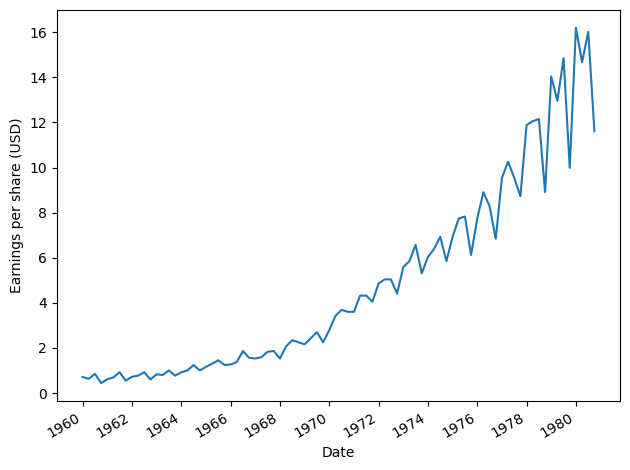

In [3]:

from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

df = pd.read_csv("/Users/maukanmir/Documents/Machine-Learning/AI-ML-Textbooks/AI-ML-Learning/Data/jj.csv")


fig, ax = plt.subplots()
 
ax.plot(df.date, df.data)
ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share (USD)')
 
plt.xticks(np.arange(0, 81, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])
 
fig.autofmt_xdate()
plt.tight_layout()

In [5]:
ad_fuller_result = adfuller(df['data'])
 
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: 2.7420165734574686
p-value: 1.0


In [6]:
eps_diff = np.diff(df['data'], n=1)
 
ad_fuller_result = adfuller(eps_diff)
 
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -0.40740976363804626
p-value: 0.9088542416911305


#### This results in an ADF statistic of –0.41 and a p-value of 0.9. Again, the ADF statistic is not a large negative number, and the p-value is larger than 0.05. Therefore, we cannot reject the null hypothesis and we must conclude that after a first-order differencing, the series is not stationary.

Let’s try differencing again to see if the series becomes stationary:

In [7]:
eps_diff2 = np.diff(eps_diff, n=1)
 
ad_fuller_result = adfuller(eps_diff2)
 
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -3.585162874793186
p-value: 0.006051099869603058


#### This results in an ADF statistic of –3.59 and a p-value of 0.006. Now that we have a p-value smaller than 0.05 and a large negative ADF statistic, we can reject the null hypothesis and conclude that our series is stationary. It took two rounds of differencing to make our data stationary, which means that our order of integration is 2, so d = 2.

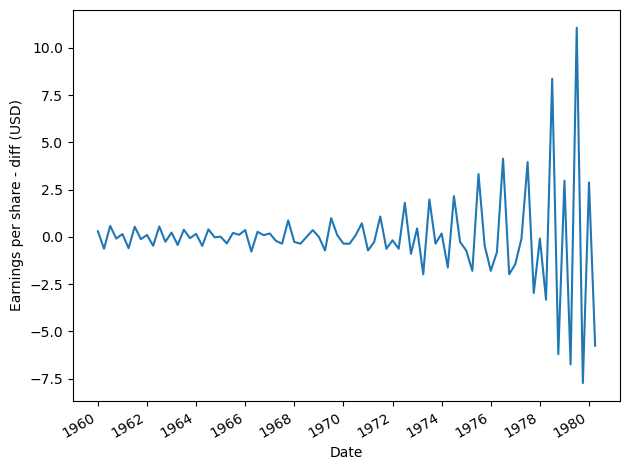

In [8]:
fig, ax = plt.subplots()

ax.plot(df['date'][2:], eps_diff2)
ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share - diff (USD)')

plt.xticks(np.arange(0, 81, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])

fig.autofmt_xdate()
plt.tight_layout()

#### To fit the many ARIMA(p,d,q) models, we’ll define the optimize_ARIMA function. It is almost identical to the optimize_ARMA function that we defined in chapter 6, only this time we’ll add the order of integration d as an input to the function. The remainder of the function stays the same, as we fit the different models and order them by ascending AIC in order to select the model with the lowest AIC. The optimize_ARIMA function is shown in the following listing.

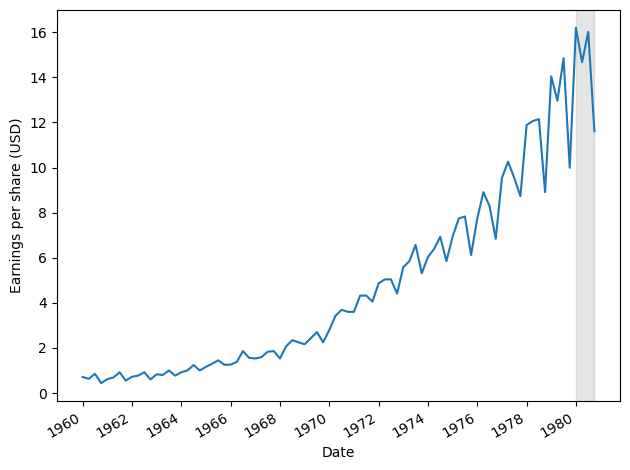

In [9]:
fig, ax = plt.subplots()

ax.plot(df.date, df.data)
ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share (USD)')
ax.axvspan(80, 83, color='#808080', alpha=0.2)

plt.xticks(np.arange(0, 81, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])

fig.autofmt_xdate()
plt.tight_layout()